# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


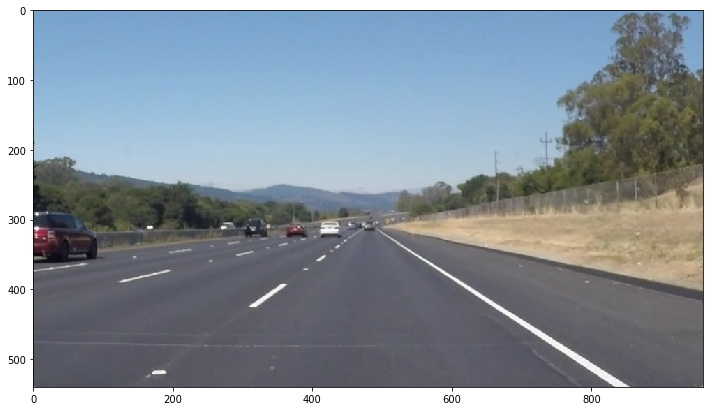

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

image = mpimg.imread('test_images/solidWhiteRight.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):

    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_lines_improved(img, lines, color=[255, 0, 0], thickness=2):

    xLeft  = []
    xRight = []
    yLeft  = []
    yRight = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)           
            
            angle = abs(math.atan(slope) * 180/math.pi)

            if angle >=20 and angle <= 70 : 
                if slope < 0:

                    xLeft.append(x1)
                    xLeft.append(x2)
                    yLeft.append(y1)
                    yLeft.append(y2)
                else:
                    xRight.append(x1)
                    xRight.append(x2)
                    yRight.append(y1)
                    yRight.append(y2)
    try:
        ext_line(img,xLeft,yLeft)
        ext_line(img,xRight,yRight)
    except:
        pass
    
def ext_line(img,x,y):
        z = np.polyfit(x,y,1)
        bottom_y = img.shape[0]
        bottom_x = int((bottom_y-z[1])/z[0])   

        top_y = 340        
        top_x = int((top_y-z[1])/z[0])

        cv2.line(img, (bottom_x, bottom_y), (top_x, top_y), [255, 0, 0], 8)
           
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_improved(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
def lane_finder(image):
    
    img_name=os.path.basename(image)
    
    org_image=mpimg.imread(image)
    
    gray_img=grayscale(org_image)
    
    blur_gray=gaussian_blur(gray_img,5)
    
    edges=canny(blur_gray,50,150)
    

    imshape=org_image.shape
    vertices = np.array([[(0,imshape[0]),(415, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges=region_of_interest(edges,vertices)
    

    line_image=hough_lines(masked_edges,2,np.pi/180, 60,70,150)  
 
    lines_edges =  weighted_img(line_image, org_image, 0.8, 1., 0.)
    

    return lines_edges, img_name

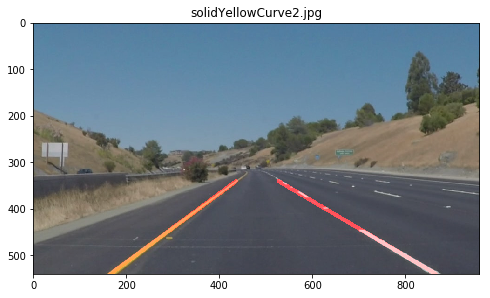

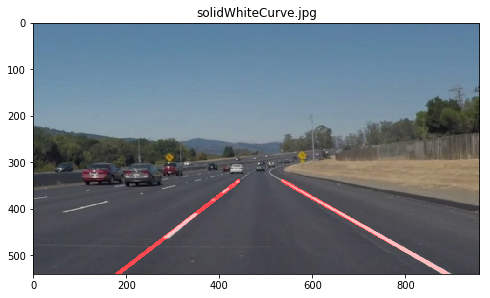

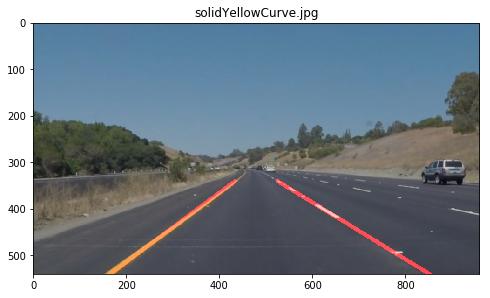

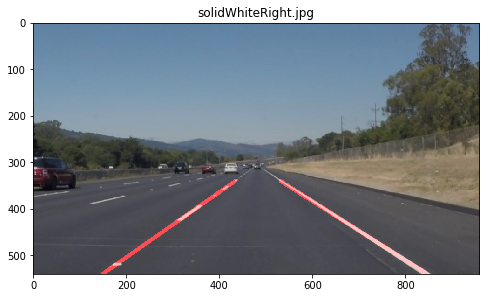

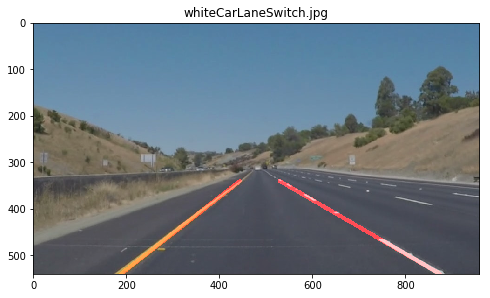

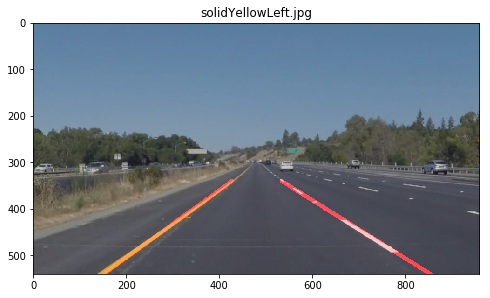

In [6]:
img=[]
name=[]

import os
img_list=os.listdir("test_images/")
for i in img_list:
    img_array,img_name= lane_finder("test_images/"+i)
    img.append(img_array)
    name.append(img_name) 
    
for i in range(len(img)):
    from pylab import rcParams
    rcParams['figure.figsize'] = 8, 8

    plt.figure(i+1)
    plt.title(name[i])
    plt.imshow(img[i])    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):

    
    gray_img=grayscale(image)
    blur_gray=gaussian_blur(gray_img,5)
    edges=canny(blur_gray,50,150)
    imshape=image.shape
    vertices = np.array([[(0,imshape[0]),(490, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges=region_of_interest(edges,vertices)
    line_image=hough_lines(masked_edges,1.5,np.pi/180, 60,10,150)  
    lines_edges =  weighted_img(line_image, image, 0.8, 1., 0.)
   
    return lines_edges

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'


clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
 

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:14<00:00, 15.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.09 s, sys: 290 ms, total: 3.38 s
Wall time: 15.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:48<00:00, 13.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.1 s, sys: 794 ms, total: 10.9 s
Wall time: 50 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


#### Step 1: Read the img
We have to read the img in np array, can use either cv2 or matplotlib but I prefer mpimg because it reads in RGB color channel instead of BGR. I also use os.path to extract the image file name for later plotting purpose

#### Step 2: Convert into gray scale
We use cv2 to turn the img array into gray scale as Canny detection read gray scale img

#### Step3: Canny Edge detection
We apply gaussian smoothing then cv2.Canny function to obtain the edge img, which are the dot of strong gradient change which may indicate the shape of object

#### Step 4: region of interest
Usually road lane line only appear in certain region of the image, such as the bottom half part, it is no use and confusing to get the edge of all objects therefore we create a region of interest area. It is also known as masking and is done by cv2.fillPoly function. The vertices I chosen are (0,imshape[0]),(415, 315), (490, 315), (imshape[1],imshape[0]), mainly by eyeball observation and trial and error. Then we make use of bitwise_and function to select the area where region of interest and canny edge detection overlap.

#### Step 5: Hough transform and drawline
We pass the above result into cv2.HoughLinesP function, which return an array of points in form of x1,y1,x2,y2. We then do a small filtering process. We calculate the slope of each set and divide them into left and right lane by the value of the slope. Then calcualte the angle, we only keep the angle with 20 to 70 degree. Again this angle is by trial and error. Then we pass the x,y coordinate into np.polyfit to fit the BEST fit line y=mx+c then plot the lane line. Each lane line is made of two points, the bottom and top point. We know the bottom y must be img.shape[0], then we pass this y into y=mx+c to get the x coordinate. For the top point, by eyeball observation to select the y value and pass into y=mx+c to get x coordinate, then we can draw a lane line by using these two points.

### Identify potential shortcomings with your current pipeline
- Obviously my pipelines cannot work well the challenging video. I guess it failed to detect lane line in color different from white. Also I mannuly set the verices points for my pipelines, if the point-of-view is different then the pipelines won't work
- what happen if there is no lane line on the road? like mountain area no painted lane

### Suggest possible improvements to your pipeline
- explore how to detect lane line in different color
- fune tune the verices and coordinate related coordinate